In [9]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, Subset
from torchvision import transforms
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from PIL import Image
from datetime import datetime
# Model Architectures
import torch
import torch.nn as nn
from torchvision import models
from PIL import ImageEnhance

In [10]:
class CustomRiceNet(nn.Module):
    def __init__(self, num_classes):
        super(CustomRiceNet, self).__init__()
        
        # Feature Extractors
        self.resnet_features = models.resnet18(weights='IMAGENET1K_V1')
        resnet_out = self.resnet_features.fc.in_features
        self.resnet_features.fc = nn.Identity()
        
        self.densenet_features = models.densenet121(weights='IMAGENET1K_V1')
        densenet_out = self.densenet_features.classifier.in_features
        self.densenet_features.classifier = nn.Identity()
        
        combined_features = resnet_out + densenet_out
        
        # Attention Mechanism
        self.attention = nn.Sequential(
            nn.Linear(combined_features, 512),
            nn.ReLU(),
            nn.Linear(512, 1),
            nn.Sigmoid()
        )
        
        # Feature Fusion
        self.fusion = nn.Sequential(
            nn.Linear(combined_features, 1024),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, 256)
        )
        
        # Classifier
        self.classifier = nn.Linear(256, num_classes)
    
    def forward(self, x):
        resnet_out = self.resnet_features(x)
        densenet_out = self.densenet_features(x)
        
        combined = torch.cat((resnet_out, densenet_out), dim=1)
        attention = self.attention(combined)
        weighted = attention * combined
        
        fused = self.fusion(weighted)
        output = self.classifier(fused)
        return output

class EfficientViTNet(nn.Module):
    def __init__(self, num_classes):
        super(EfficientViTNet, self).__init__()
        
        # EfficientNet Feature Extractor
        self.efficient_net = models.efficientnet_b0(weights='IMAGENET1K_V1')
        efficient_features = self.efficient_net.classifier[1].in_features
        self.efficient_net.classifier = nn.Identity()
        
        # ViT Feature Extractor
        self.vit = models.vit_b_16(weights='IMAGENET1K_V1')
        vit_features = self.vit.heads.head.in_features
        self.vit.heads = nn.Identity()
        
        # Feature Fusion
        combined_features = efficient_features + vit_features
        self.fusion = nn.Sequential(
            nn.Linear(combined_features, 512),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Dropout(0.3)
        )
        
        # Classifier
        self.classifier = nn.Linear(256, num_classes)
    
    def forward(self, x):
        efficient_features = self.efficient_net(x)
        vit_features = self.vit(x)
        
        combined = torch.cat((efficient_features, vit_features), dim=1)
        fused = self.fusion(combined)
        output = self.classifier(fused)
        return output

class InceptionResNetModel(nn.Module):
    def __init__(self, num_classes):
        super(InceptionResNetModel, self).__init__()

        # InceptionV3 Feature Extractor
        self.inception = models.inception_v3(weights='IMAGENET1K_V1', aux_logits=True)
        inception_features = self.inception.fc.in_features
        self.inception.fc = nn.Identity()

        # ResNet50 Feature Extractor
        self.resnet = models.resnet50(weights='IMAGENET1K_V1')
        resnet_features = self.resnet.fc.in_features
        self.resnet.fc = nn.Identity()

        # Feature Weighting
        combined_features = inception_features + resnet_features
        self.attention = nn.Sequential(
            nn.Linear(combined_features, 512),
            nn.Tanh(),
            nn.Linear(512, 2),
            nn.Softmax(dim=1)
        )

        # Feature Fusion and Classifier
        self.classifier = nn.Sequential(
            nn.Linear(combined_features, 512),
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Linear(256, num_classes)
        )

    def forward(self, x):
        # InceptionV3 requires input size (299, 299)
        x = nn.functional.interpolate(x, size=(299, 299), mode='bilinear', align_corners=False)

        # Forward pass through InceptionV3
        inception_out, _ = self.inception(x)  # We only take the main output (ignore auxiliary)

        # Forward pass through ResNet50
        resnet_out = self.resnet(x)

        # Combine features
        combined = torch.cat((inception_out, resnet_out), dim=1)

        # Apply attention
        weights = self.attention(combined)
        weighted_features = torch.cat((
            weights[:, 0].unsqueeze(1) * inception_out,
            weights[:, 1].unsqueeze(1) * resnet_out
        ), dim=1)

        # Final classification
        output = self.classifier(weighted_features)
        return output

class ConvNextSwinModel(nn.Module):
    def __init__(self, num_classes):
        super(ConvNextSwinModel, self).__init__()
        
        # ConvNext Feature Extractor
        self.convnext = models.convnext_tiny(weights='IMAGENET1K_V1')
        convnext_features = self.convnext.classifier[2].in_features
        self.convnext.classifier = nn.Identity()
        
        # Swin Transformer Feature Extractor
        self.swin = models.swin_t(weights='IMAGENET1K_V1')
        swin_features = self.swin.head.in_features
        self.swin.head = nn.Identity()
        
        # Feature Processing
        self.convnext_proj = nn.Linear(convnext_features, 512)
        self.swin_proj = nn.Linear(swin_features, 512)
        
        # Cross-Attention
        self.cross_attention = nn.MultiheadAttention(
            embed_dim=512,
            num_heads=8,
            dropout=0.1
        )
        
        # Classifier
        self.classifier = nn.Sequential(
            nn.Linear(512, 256),
            nn.LayerNorm(256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, num_classes)
        )
    
    def forward(self, x):
        convnext_features = self.convnext(x)
        swin_features = self.swin(x)
        
        convnext_proj = self.convnext_proj(convnext_features)
        swin_proj = self.swin_proj(swin_features)
        
        attended_features, _ = self.cross_attention(
            convnext_proj.unsqueeze(0),
            swin_proj.unsqueeze(0),
            swin_proj.unsqueeze(0)
        )
        
        output = self.classifier(attended_features.squeeze(0))
        return output

In [11]:
# Custom metrics calculation functions
class MetricsCalculator:
    @staticmethod
    def calculate_accuracy(outputs, targets):
        """Custom accuracy calculation"""
        predictions = torch.argmax(outputs, dim=1)
        correct = (predictions == targets).sum().item()
        total = targets.size(0)
        return (correct / total) * 100
    
    @staticmethod
    def calculate_precision_recall(outputs, targets, num_classes):
        """Custom precision and recall calculation"""
        predictions = torch.argmax(outputs, dim=1)
        
        # Initialize counters for each class
        true_positives = torch.zeros(num_classes)
        false_positives = torch.zeros(num_classes)
        false_negatives = torch.zeros(num_classes)
        
        # Calculate metrics for each class
        for class_idx in range(num_classes):
            predicted_class = predictions == class_idx
            actual_class = targets == class_idx
            
            true_positives[class_idx] = (predicted_class & actual_class).sum().item()
            false_positives[class_idx] = (predicted_class & ~actual_class).sum().item()
            false_negatives[class_idx] = (~predicted_class & actual_class).sum().item()
        
        # Calculate precision and recall
        precision = true_positives / (true_positives + false_positives + 1e-8)
        recall = true_positives / (true_positives + false_negatives + 1e-8)
        
        return precision, recall
    
    @staticmethod
    def calculate_f1_score(precision, recall):
        """Custom F1 score calculation"""
        return 2 * (precision * recall) / (precision + recall + 1e-8)



In [12]:
# Custom data augmentation functions
class CustomAugmentation:
    @staticmethod
    def random_rotate(image, max_angle=30):
        """Custom rotation augmentation"""
        angle = np.random.uniform(-max_angle, max_angle)
        return image.rotate(angle)
    
    @staticmethod
    def random_flip(image):
        """Custom flip augmentation"""
        if np.random.random() > 0.5:
            image = image.transpose(Image.FLIP_LEFT_RIGHT)
        if np.random.random() > 0.5:
            image = image.transpose(Image.FLIP_TOP_BOTTOM)
        return image
    
    @staticmethod
    def random_brightness(image, factor_range=(0.8, 1.2)):
        """Custom brightness augmentation"""
        factor = np.random.uniform(*factor_range)
        enhancer = ImageEnhance.Brightness(image)
        return enhancer.enhance(factor)
    
    @staticmethod
    def random_contrast(image, factor_range=(0.8, 1.2)):
        """Custom contrast augmentation"""
        factor = np.random.uniform(*factor_range)
        enhancer = ImageEnhance.Contrast(image)
        return enhancer.enhance(factor)


In [13]:
# Custom dataset class with augmentation
class CustomRiceDiseaseDataset(Dataset):
    def __init__(self, csv_file, base_path, transform=None, augment=False):
        self.data = self._load_data(csv_file)
        self.base_path = base_path
        self.transform = transform
        self.augment = augment
        self.label_mapping = self._create_label_mapping()
        self.valid_data = self._validate_data()
        self.augmentor = CustomAugmentation()
    
    def _load_data(self, csv_file):
        """Custom CSV loading with error handling"""
        try:
            return pd.read_csv(csv_file)
        except Exception as e:
            raise Exception(f"Error loading CSV file: {str(e)}")
    
    def _create_label_mapping(self):
        """Custom label mapping creation"""
        unique_labels = sorted(self.data['label'].unique())
        return {label: idx for idx, label in enumerate(unique_labels)}
    
    def _validate_data(self):
        """Custom data validation"""
        valid_data = []
        for _, row in self.data.iterrows():
            img_path = os.path.join(self.base_path, row['label'], row['image_id'])
            if os.path.exists(img_path):
                valid_data.append({
                    'image_path': img_path,
                    'label': row['label']
                })
        return valid_data
    
    def _apply_augmentation(self, image):
        """Apply custom augmentations"""
        image = self.augmentor.random_flip(image)
        image = self.augmentor.random_rotate(image)
        image = self.augmentor.random_brightness(image)
        image = self.augmentor.random_contrast(image)
        return image
    
    def __len__(self):
        return len(self.valid_data)
    
    def __getitem__(self, idx):
        item = self.valid_data[idx]
        image = Image.open(item['image_path']).convert('RGB')
        
        if self.augment:
            image = self._apply_augmentation(image)
        
        if self.transform:
            image = self.transform(image)
        
        label = self.label_mapping[item['label']]
        return image, label



In [14]:
import os
import torch
import matplotlib.pyplot as plt
from tqdm import tqdm  # For progress bars


class CustomModelTrainer:
    def __init__(self, model, criterion, optimizer, device, model_name):
        self.model = model
        self.criterion = criterion
        self.optimizer = optimizer
        self.device = device
        self.model_name = model_name
        self.metrics = MetricsCalculator()
        self.history = self._initialize_history()

    def _initialize_history(self):
        """Initialize custom history tracking"""
        return {
            'train_loss': [], 'train_acc': [], 'train_f1': [],
            'val_loss': [], 'val_acc': [], 'val_f1': [],
            'learning_rates': []
        }

    def _train_epoch(self, train_loader, num_classes):
        """Custom training epoch with batch progress bar"""
        self.model.train()
        epoch_loss = 0
        all_outputs = []
        all_targets = []

        # Use tqdm for batch-level progress
        batch_progress = tqdm(train_loader, desc="Training", leave=False)
        for batch_idx, (inputs, targets) in enumerate(batch_progress):
            inputs, targets = inputs.to(self.device), targets.to(self.device)

            # Forward pass
            self.optimizer.zero_grad()
            outputs = self.model(inputs)
            loss = self.criterion(outputs, targets)

            # Backward pass
            loss.backward()
            self.optimizer.step()

            # Store batch results
            epoch_loss += loss.item()
            all_outputs.append(outputs.detach())
            all_targets.append(targets)

            # Update progress bar
            batch_progress.set_postfix(loss=loss.item())

        # Concatenate all batches
        all_outputs = torch.cat(all_outputs)
        all_targets = torch.cat(all_targets)

        # Calculate metrics
        accuracy = self.metrics.calculate_accuracy(all_outputs, all_targets)
        precision, recall = self.metrics.calculate_precision_recall(all_outputs, all_targets, num_classes)
        f1_score = self.metrics.calculate_f1_score(precision, recall).mean()

        return epoch_loss / len(train_loader), accuracy, f1_score

    def _validate_epoch(self, val_loader, num_classes):
        """Custom validation epoch with progress bar"""
        self.model.eval()
        epoch_loss = 0
        all_outputs = []
        all_targets = []

        # Use tqdm for validation progress
        batch_progress = tqdm(val_loader, desc="Validation", leave=False)
        with torch.no_grad():
            for inputs, targets in batch_progress:
                inputs, targets = inputs.to(self.device), targets.to(self.device)
                outputs = self.model(inputs)
                loss = self.criterion(outputs, targets)

                epoch_loss += loss.item()
                all_outputs.append(outputs)
                all_targets.append(targets)

        all_outputs = torch.cat(all_outputs)
        all_targets = torch.cat(all_targets)

        accuracy = self.metrics.calculate_accuracy(all_outputs, all_targets)
        precision, recall = self.metrics.calculate_precision_recall(all_outputs, all_targets, num_classes)
        f1_score = self.metrics.calculate_f1_score(precision, recall).mean()

        return epoch_loss / len(val_loader), accuracy, f1_score

    def train(self, train_loader, val_loader, num_epochs, num_classes, save_dir):
        """Custom training loop with progress tracking"""
        best_val_loss = float('inf')

        for epoch in range(num_epochs):
            print(f"\nEpoch {epoch + 1}/{num_epochs}")
            print("-" * 30)

            # Training phase
            train_loss, train_acc, train_f1 = self._train_epoch(train_loader, num_classes)

            # Validation phase
            val_loss, val_acc, val_f1 = self._validate_epoch(val_loader, num_classes)

            # Store metrics
            self.history['train_loss'].append(train_loss)
            self.history['train_acc'].append(train_acc)
            self.history['train_f1'].append(train_f1)
            self.history['val_loss'].append(val_loss)
            self.history['val_acc'].append(val_acc)
            self.history['val_f1'].append(val_f1)
            self.history['learning_rates'].append(
                self.optimizer.param_groups[0]['lr']
            )

            # Print progress
            print(f"Train - Loss: {train_loss:.4f}, Acc: {train_acc:.2f}%, F1: {train_f1:.4f}")
            print(f"Val - Loss: {val_loss:.4f}, Acc: {val_acc:.2f}%, F1: {val_f1:.4f}")

            # Save best model
            if val_loss < best_val_loss:
                best_val_loss = val_loss
                self._save_model(epoch, save_dir, val_loss, val_acc)

        # Plot training history
        self._plot_training_history()

        return self.history

    def _save_model(self, epoch, save_dir, val_loss, val_acc):
        """Custom model saving"""
        save_path = os.path.join(save_dir, f"{self.model_name}_best.pth")
        torch.save({
            'epoch': epoch,
            'model_state_dict': self.model.state_dict(),
            'optimizer_state_dict': self.optimizer.state_dict(),
            'val_loss': val_loss,
            'val_acc': val_acc
        }, save_path)
        print(f"Saved best model to {save_path}.")


    def _plot_training_history(self):
        """Plot training and validation metrics"""
        epochs = range(1, len(self.history['train_loss']) + 1)

        # Plot loss
        plt.figure(figsize=(12, 6))
        plt.subplot(1, 2, 1)
        plt.plot(epochs, self.history['train_loss'], label="Train Loss")
        plt.plot(epochs, self.history['val_loss'], label="Val Loss")
        plt.title("Loss")
        plt.xlabel("Epoch")
        plt.ylabel("Loss")
        plt.legend()

        # Plot accuracy
        plt.subplot(1, 2, 2)
        plt.plot(epochs, self.history['train_acc'], label="Train Accuracy")
        plt.plot(epochs, self.history['val_acc'], label="Val Accuracy")
        plt.title("Accuracy")
        plt.xlabel("Epoch")
        plt.ylabel("Accuracy (%)")
        plt.legend()

        plt.tight_layout()
        plt.show()

In [15]:
# Custom visualization class
class CustomVisualizer:
    @staticmethod
    def plot_training_history(histories, save_dir):
        """Custom plotting function"""
        metrics = ['loss', 'acc', 'f1']
        fig, axes = plt.subplots(len(metrics), 1, figsize=(15, 5*len(metrics)))
        
        for idx, metric in enumerate(metrics):
            ax = axes[idx]
            
            for model_name, history in histories.items():
                train_metric = history[f'train_{metric}']
                val_metric = history[f'val_{metric}']
                
                ax.plot(train_metric, label=f'{model_name} Train')
                ax.plot(val_metric, label=f'{model_name} Val')
                
            ax.set_title(f'{metric.upper()} vs Epoch')
            ax.set_xlabel('Epoch')
            ax.set_ylabel(metric.upper())
            ax.legend()
            ax.grid(True)
        
        plt.tight_layout()
        plt.savefig(os.path.join(save_dir, 'training_comparison.png'))
        plt.close()



Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 177MB/s]
Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /root/.cache/torch/hub/checkpoints/densenet121-a639ec97.pth
100%|██████████| 30.8M/30.8M [00:00<00:00, 164MB/s] 
Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-7f5810bc.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-7f5810bc.pth
100%|██████████| 20.5M/20.5M [00:00<00:00, 141MB/s] 
Downloading: "https://download.pytorch.org/models/vit_b_16-c867db91.pth" to /root/.cache/torch/hub/checkpoints/vit_b_16-c867db91.pth
100%|██████████| 330M/330M [00:01<00:00, 210MB/s]  



Training CustomRiceNet

Epoch 1/2
------------------------------


Train - Loss: 2.0984, Acc: 23.00%, F1: 0.1101
Val - Loss: 1.9147, Acc: 28.36%, F1: 0.1071
Saved best model to classification_results.csv/CustomRiceNet_best.pth.

Epoch 2/2
------------------------------


Train - Loss: 1.9231, Acc: 30.47%, F1: 0.1515
Val - Loss: 2.0116, Acc: 25.18%, F1: 0.1160


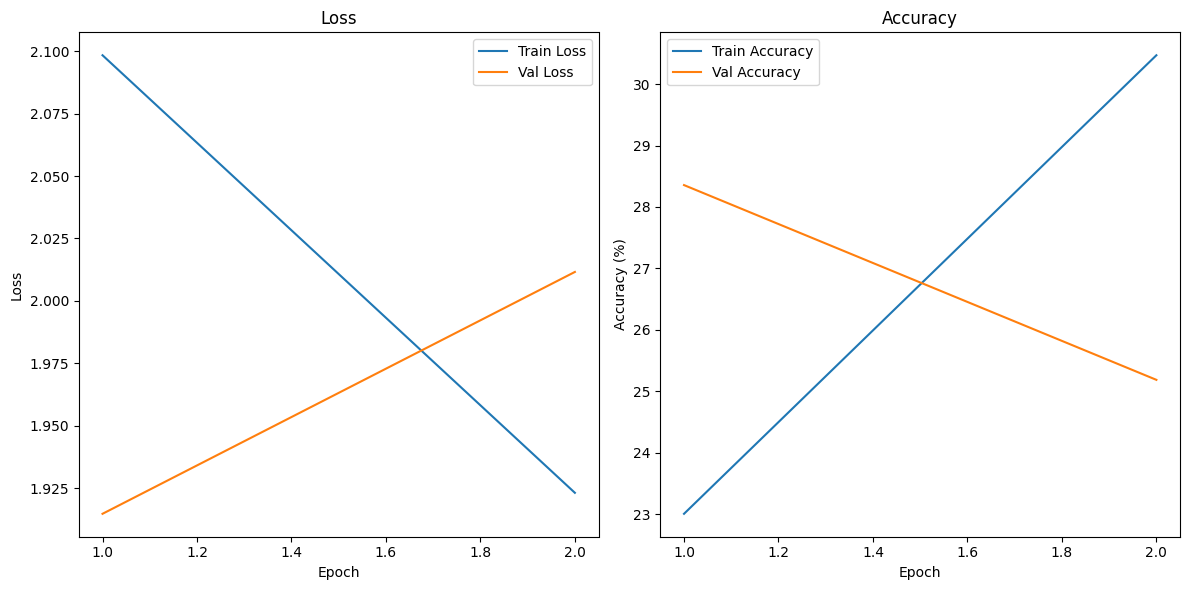


Training EfficientViTNet

Epoch 1/2
------------------------------


Train - Loss: 1.5160, Acc: 49.87%, F1: 0.3510
Val - Loss: 1.0145, Acc: 65.94%, F1: 0.5136
Saved best model to classification_results.csv/EfficientViTNet_best.pth.

Epoch 2/2
------------------------------


Train - Loss: 0.9968, Acc: 68.03%, F1: 0.5837
Val - Loss: 0.8242, Acc: 73.79%, F1: 0.6683
Saved best model to classification_results.csv/EfficientViTNet_best.pth.


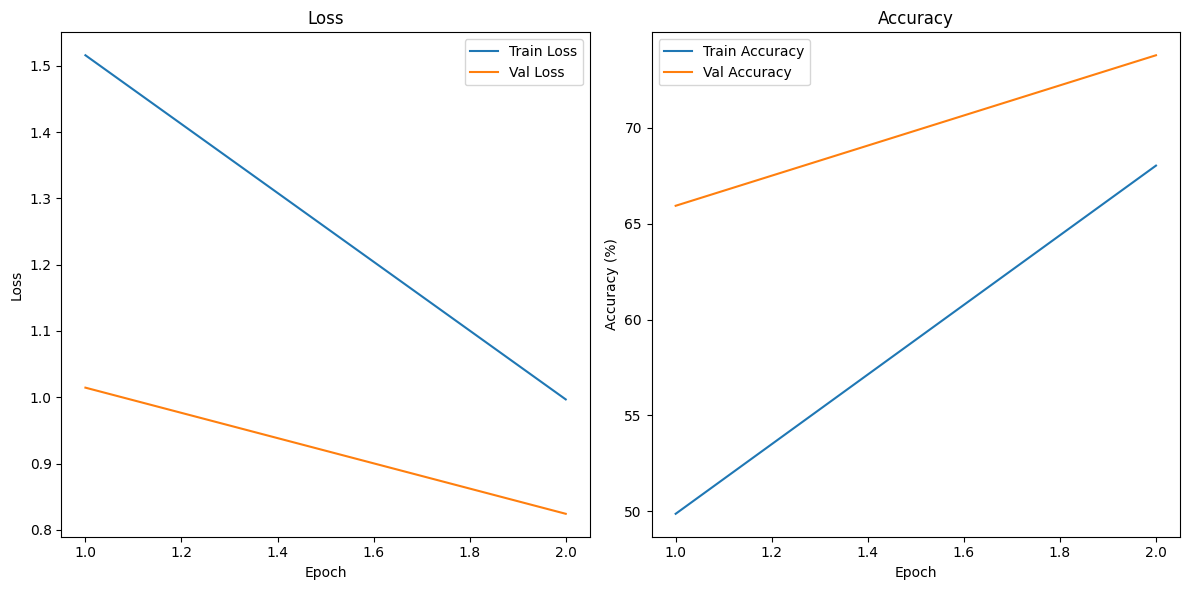

In [16]:
def main():
    # Configuration
    config = {
        'csv_file': '/kaggle/input/paddydoctor/train.csv',
        'train_dir': '/kaggle/input/paddydoctor/train_images',
        'test_dir': '/kaggle/input/paddydoctor/test_images',
        'save_dir': 'classification_results.csv',
        'batch_size': 16,
        'num_epochs': 2,
        'learning_rate': 0.001
    }
    
    # Create save directory
    os.makedirs(config['save_dir'], exist_ok=True)
    
    # Device setup
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    
    # Create datasets with custom augmentation
    train_dataset = CustomRiceDiseaseDataset(
        config['csv_file'],
        config['train_dir'],
        transform=transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ]),
        augment=True
    )
    
    # Initialize models and training
    models = {
        'CustomRiceNet': CustomRiceNet(num_classes=len(train_dataset.label_mapping)),
        'EfficientViTNet': EfficientViTNet(num_classes=len(train_dataset.label_mapping))
        # 'InceptionResNetModel': InceptionResNetModel(num_classes=len(train_dataset.label_mapping)),
        # 'ConvNextSwinModel': ConvNextSwinModel(num_classes=len(train_dataset.label_mapping))
    }
    
    # Train all models and store histories
    histories = {}
    for model_name, model in models.items():
        print(f"\nTraining {model_name}")
        model = model.to(device)
        
        trainer = CustomModelTrainer(
            model=model,
            criterion=nn.CrossEntropyLoss(),
            optimizer=optim.Adam(model.parameters(), lr=config['learning_rate']),
            device=device,
            model_name=model_name
        )
        
        history = trainer.train(
            train_loader=DataLoader(train_dataset, batch_size=config['batch_size'], shuffle=True),
            val_loader=DataLoader(train_dataset, batch_size=config['batch_size'], shuffle=False),
            num_epochs=config['num_epochs'],
            num_classes=len(train_dataset.label_mapping),
            save_dir=config['save_dir']
        )
        
        histories[model_name] = history
    
    # Plot results
    visualizer = CustomVisualizer()
    visualizer.plot_training_history(histories, config['save_dir'])

if __name__ == "__main__":
    main()